In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import simps

In [2]:
# Constants
NA = 6.02214076E23  # Avogadro's number

In [3]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


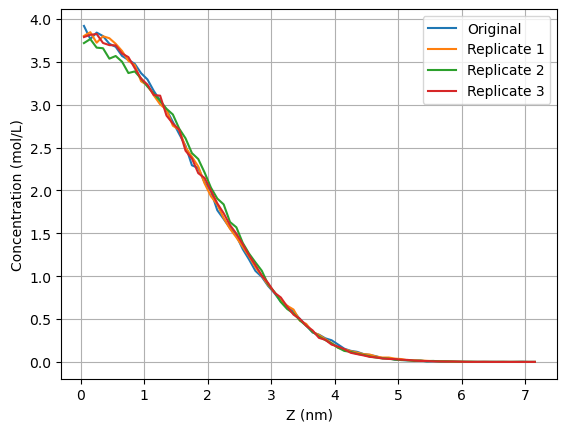

In [4]:
z_0, c_0 = compute_c_profile("density_hwl.xvg")
z_1, c_1 = compute_c_profile("density_hwr1.xvg")  # replicate 1
z_2, c_2 = compute_c_profile("density_hwr2.xvg")  # replicate 2
z_3, c_3 = compute_c_profile("density_hwr3.xvg")  # replicate 3

# Plot the concentration profiles
plt.figure()
plt.plot(z_0, c_0, label="Original")
plt.plot(z_1, c_1, label="Replicate 1")
plt.plot(z_2, c_2, label="Replicate 2")
plt.plot(z_3, c_3, label="Replicate 3")
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()


In [5]:
# Estimate the total number of ions, N_s (using Equation 13)
L_x, L_y, L_z = 4.8, 4.8, 14.4
N_s = L_x * L_y * simps(c_0, z_0)
print(N_s)  # this should be around 188

187.97002947984


In [16]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Here we convert the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    # A /= (conversion_factor ** 0.5)

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)

    term_1 = -np.log(x / C_max)
    term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    term_4 = alpha_1 * (x - C_max) + alpha_2 * (x ** 2 - C_max ** 2)

    y = term_1 + term_2 + term_3 + term_4

    return y

In [23]:
def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [30]:
# Remove 0 values from the concentration profile, and the corresponding z values
z_0 = z_0[c_0 != 0]
c_0 = c_0[c_0 != 0]

# Calculate -U(z) / RT (y_values below)
k = 1.0457  # units: kJ/mol/nm^2
R = 8.31446261815324  # units: J/(mol*K)
T = 300  # units: K
y_values = -(0.5 * k * z_0 ** 2) * 1000 / (R * T)

result = least_squares(residuals, [2, 0.1, 0.1], args=(c_0, y_values))

# At this point, B, alpha_1, and alpha_2 have units of [nm^(-3)]^(-1/2), [nm^(-3)]^(-1), and [nm^(-3)]^(-2), respectively
B, alpha_1, alpha_2 = result.x[0], result.x[1], result.x[2]

# Below we convert nm^(-3) to mol/L for the three parameters
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
B *= (conversion_factor ** (-0.5))  # units M^(-1/2)
alpha_1 *= (conversion_factor ** (-1))  # units M^(-1)
alpha_2 *= (conversion_factor ** (-2))  # units M^(-2)


In [31]:
result.x

array([ 4.51465389e+04,  1.11800318e+01, -1.98882080e+00])

In [32]:
print(B, alpha_1, alpha_2)

35034.82180226101 6.732772510687919 -0.7212693176577659


In [34]:
result.cost

6165.3300657423815

In [35]:
result.optimality

0.00023725486971670762

In [33]:
# nm-based answers
print(1.9247 / (conversion_factor ** (-0.5)))
print(9.3393E-2 / (conversion_factor ** (-1)))
print(3.4572E-2 / (conversion_factor)**(-2))

2.4802050938626055
0.15508272510056706
0.09532848685910528
